In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install koreanize-matplotlib
import koreanize_matplotlib
%matplotlib inline
import os
os.getcwd()


'/content'

In [6]:
from scipy import stats as spst


In [3]:
orders = pd.read_csv("./drive/MyDrive/데이터분석/project1/olist_orders_dataset.csv")
order_items = pd.read_csv("./drive/MyDrive/데이터분석/project1/olist_order_items_dataset.csv")
payments = pd.read_csv("./drive/MyDrive/데이터분석/project1/olist_order_payments_dataset.csv")
reviews = pd.read_csv("./drive/MyDrive/데이터분석/project1/olist_order_reviews_dataset.csv")
customers = pd.read_csv("./drive/MyDrive/데이터분석/project1/olist_customers_dataset.csv")
sellers = pd.read_csv("./drive/MyDrive/데이터분석/project1/olist_sellers_dataset.csv")
products = pd.read_csv("./drive/MyDrive/데이터분석/project1/olist_products_dataset.csv")
geolocation = pd.read_csv("./drive/MyDrive/데이터분석/project1/olist_geolocation_dataset.csv")
categories = pd.read_csv("./drive/MyDrive/데이터분석/project1/product_category_name_translation.csv")

## 지연 여부에 따른 평균 리뷰 점수

/tmp/ipython-input-4-2703693290.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_clean['order_delivered_customer_date'] = pd.to_datetime(orders_clean['order_delivered_customer_date'])
/tmp/ipython-input-4-2703693290.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_clean['order_estimated_delivery_date'] = pd.to_datetime(orders_clean['order_estimated_delivery_date'])
/tmp/ipython-input-4-2703693290.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

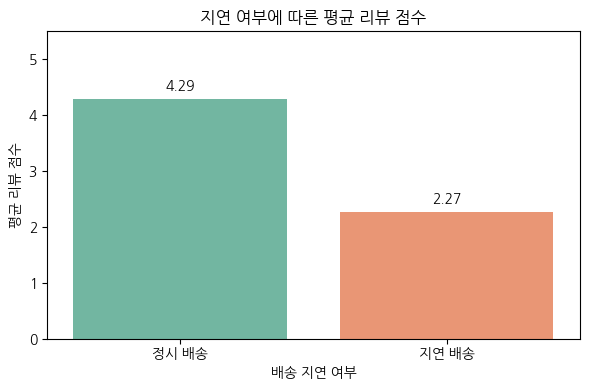

In [4]:
# 1단계 : null 값이 있는 행 제거 (배송일, 예상일, 별점 모두 있어야 분석 가능)
orders_clean = orders.dropna(subset=['order_delivered_customer_date', 'order_estimated_delivery_date'])
reviews_clean = reviews.dropna(subset=['review_score'])

# 2단계 : 날짜 타입 변환 (이미 되었지만 안전하게 다시 처리)
orders_clean['order_delivered_customer_date'] = pd.to_datetime(orders_clean['order_delivered_customer_date'])
orders_clean['order_estimated_delivery_date'] = pd.to_datetime(orders_clean['order_estimated_delivery_date'])

# 3단계 : 지연 여부 컬럼 추가 _ 예상 배송일(24시까지)보다 늦은 경우
orders_clean['is_late']= orders_clean['order_delivered_customer_date'] > orders_clean['order_estimated_delivery_date']+ pd.Timedelta(days=1)

# 4단계 : orders와 reviews 데이터 병합
merged_df = pd.merge(
    orders_clean[['order_id', 'is_late']],
    reviews_clean[['order_id', 'review_score']],
    on='order_id'
)

# 5단계 : 지연 여부와 리뷰 점수 간 상관관계 분석
late_avg = merged_df.groupby('is_late')['review_score'].mean().reset_index()

# 6단계 : 시각화
plt.figure(figsize=(6, 4))
barplot = sns.barplot(data=late_avg, x='is_late', y='review_score', palette='Set2')
plt.xticks([0, 1], ['정시 배송', '지연 배송'])
plt.title('지연 여부에 따른 평균 리뷰 점수')
plt.ylabel('평균 리뷰 점수')
plt.xlabel('배송 지연 여부')
plt.ylim(0, 5.5)
plt.tight_layout()

for p in barplot.patches:
    # 막대의 높이 (평균 리뷰 점수)
    height = p.get_height()
    # 텍스트 위치 (막대 중앙)
    barplot.text(p.get_x() + p.get_width() / 2, height + 0.1, # x, y좌표 (막대 높이보다 약간 위)
                 f'{height:.2f}', ha='center', va='bottom', fontsize=10, color='black')
# 결과 출력
plt.show()




## 지연 배송과 별점 간 상관분석 결과

In [8]:
## 상관 분석용 상관계수 (지연 여부와 별점 간 피어슨 상관계수)
correlation = merged_df[['is_late', 'review_score']].corr().iloc[0, 1]
print(f'- 지연 여부와 별점 간 피어슨 상관계수 {correlation}')
print('지연 여부와 별점은 음의 상관관계를 갖는다.')

- 지연 여부와 별점 간 피어슨 상관계수 -0.39144441509913175
지연 여부와 별점은 음의 상관관계를 갖는다.


## 배송 지연 여부와 부정적인 리뷰 간의 상관관계 (p-value 기반 분석)



예상 날짜 이후에 배송된 주문이 부정적인 리뷰(3점 이하)를 받을 가능성이 더 높은지 검정한다.

- 귀무가설(H₀): 배송 지연은 부정적인 리뷰 발생 가능성을 증가시키지 않는다.

- 대립가설(H₁): 배송 지연은 부정적인 리뷰 발생 가능성을 증가시킨다.


In [7]:
# 1. 부정적 리뷰 여부 컬럼 추가 (True: 3점 이하)
merged_df['is_negative_review'] = merged_df['review_score'] <= 3

# 2. 피어슨 상관계수 계산을 위해 bool → int 변환 (True=1, False=0)
x = merged_df['is_late'].astype(int)  # 배송 지연 여부
y = merged_df['is_negative_review'].astype(int)  # 부정적 리뷰 여부

# 3. 배송 지연과 3점 이하 리뷰 // 피어슨 상관계수와 p-value 계산
correlation_coefficient, p_value = spst.pearsonr(x, y)

print(f"- 배송 지연과 부정적인 리뷰 p-value: {p_value:.2f}")

- 배송 지연과 부정적인 리뷰 p-value: 0.00


p-value < 0.05 (실질적으로 0)

> 일반적인 알파 수준(0.05)에서 통계적으로 유의미하다.

